In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef, classification_report, confusion_matrix, balanced_accuracy_score
import h5py
from joblib import load
import random
import math

## Calculating Bootstrapped Data

In [4]:
#calculating bootstrapped inputs
val_f = h5py.File('data/annots_embeds_per_residue_val.hdf5', 'r')
X_val = np.array(val_f['val_embeds'])
y_val = np.array(val_f['val_annots'])
proteins = np.array(val_f['val_indv'])
test_f = h5py.File('data/annots_embeds_per_residue_test.hdf5', 'r')
X_test = np.array(test_f['test_embeds'])
y_test = np.array(test_f['test_annots'])
#proteins = np.array(test_f['test_indv'])

classifier = load('data/saved_notebook_model.joblib')


print(proteins)
print(len(proteins))
#k=127 VALIDATION
#k=188 TEST

prots = np.empty((len(proteins),2))
random_prots = np.empty((len(proteins)))
curr = 0
for i in range(len(prots)):
    random_prots[i] = curr
    curr+=1
print(random_prots)

sum = 0
#dictionary with protein index as key, and range of residues that belong to that protein for easy selection
dict_prots = {}
for i in range(len(proteins)):
    dict_prots[i] = [(proteins[i] - proteins[i] + sum), (proteins[i] + sum - 1)]
    #prots[i][0] = proteins[i] - proteins[i] + sum
    #prots[i][1] = proteins[i] + sum - 1
    sum += proteins[i]
print(dict_prots)

#bs = np.random.choice(random, (1000, len(random)), replace=True)
#print(bs)



[ 347.  347.  342.  338.  336.  336.  336.  335.  330.  329.  324.  322.
  320.  319.  318.  313.  981.  307.  304.  304.  970.  302.  302.  298.
  294.  285.  285.  282.  281.  280.  936.  277.  265.  264.  910.  257.
  253.  249.  900.  247.  244.  243.  240.  240.  240.  238.  236.  232.
  231.  883.  229.  222.  874.  216.  873.  212.  211.  202.  195.  194.
  856.  856.  189.  186.  184.  183.  176.  176.  173.  831.  151.  141.
  130.  126.  105.  104.  100.   99.   94.  809. 2073.  765.  749.  720.
  708.  684.  684. 4723.  660.  617.  614.  599.  597.  537.  527.  526.
  520. 1367. 1321.  488. 3726.  472.  472.  472.  471. 1250.  468.  462.
  460.  454.  450.  446. 1187.  437.  433.  400.  388. 1087.  383.  377.
  377. 1070.  371.  364. 1040.  353.  351.]
127
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43

In [3]:
classifier

MLPClassifier(hidden_layer_sizes=(512, 380, 156, 49), max_iter=100,
              verbose=True)

In [4]:
def per_protein_evaluation(dict_prots, rand_choice, predictions):
    per_prot_likely = np.ndarray((len(proteins),7))
    count=0
    current = 0
    for i in range(len(rand_choice)):
        tally = np.zeros(7)
        for j in range(int(current), int(current + (dict_prots[rand_choice[i]][1]-dict_prots[rand_choice[i]][0]))):
            tally[predictions[j]-1] += 1
        #print(tally)
        class_likelihood = np.zeros(7)
        for k in range(7):
            class_likelihood[k] = tally[k]/(dict_prots[rand_choice[i]][1]-dict_prots[rand_choice[i]][0])
        per_prot_likely[count] = class_likelihood
        count += 1
        current += (dict_prots[rand_choice[i]][1]-dict_prots[rand_choice[i]][0])
    
    prot_preds = np.array([])
    for pred in per_prot_likely:
        prot_preds = np.append(prot_preds, np.argmax(pred)+1)
    return prot_preds


In [16]:
def single_sample_scores(classifier, dict_prots):
    cur_Xsample = []
    cur_ysample = []
    cur_yprotsample = []
    rand_choice = np.random.choice(random_prots, len(proteins))
    for i in range(len(rand_choice)):
        start = int(dict_prots[rand_choice[i]][0])
        #print(start)
        end = int(dict_prots[rand_choice[i]][1])
        #print(end)
        #print(y_val[start:end])
        cur_Xsample.append(X_val[start:end])
        cur_ysample.append(y_val[start:end])
        cur_yprotsample.append(y_val[start])
    X_sample = np.concatenate(np.asarray(cur_Xsample, dtype=object), axis=0)
    y_sample_residues = np.concatenate(np.asarray(cur_ysample, dtype=object), axis=0)
    y_sample = np.asarray(cur_yprotsample)
    #print(X_sample.shape) 
    #print(y_sample_residues.shape)
    #print(y_sample.shape)
    residue_predictions = classifier.predict(X_sample)
    predictions = per_protein_evaluation(dict_prots, rand_choice, residue_predictions)
    #print(predictions)
    #print(y_sample)
    acc = accuracy_score(y_sample, predictions)
    f1 = f1_score(y_sample, predictions, average='weighted')
    mcc = matthews_corrcoef(y_sample, predictions)

    return acc, f1, mcc

In [14]:
acc, f1, mcc = single_sample_scores(classifier, dict_prots)
print(acc, f1, mcc)

[1. 1. 2. 4. 3. 1. 1. 1. 6. 1. 2. 1. 2. 6. 3. 1. 2. 2. 2. 3. 6. 3. 2. 1.
 2. 1. 3. 2. 3. 2. 2. 2. 1. 3. 3. 2. 2. 1. 5. 3. 2. 2. 2. 1. 3. 2. 2. 1.
 2. 1. 1. 2. 2. 3. 3. 3. 2. 2. 1. 2. 3. 2. 3. 1. 3. 2. 1. 1. 3. 6. 2. 2.
 3. 2. 1. 1. 2. 3. 3. 3. 2. 1. 1. 1. 3. 2. 3. 3. 1. 3. 1. 2. 2. 3. 4. 1.
 3. 3. 2. 4. 3. 1. 3. 2. 3. 2. 3. 2. 2. 4. 2. 3. 2. 1. 3. 5. 3. 3. 2. 4.
 1. 2. 3. 2. 1. 3. 1.]
[1 1 2 4 1 5 6 1 6 1 2 1 3 6 3 4 2 2 2 3 6 3 2 1 2 4 5 2 3 3 3 3 1 3 5 4 2
 1 5 3 3 4 2 2 3 2 2 4 2 1 1 2 2 2 3 3 2 2 1 4 3 2 3 5 3 2 1 5 3 6 2 2 1 2
 1 1 2 3 3 3 3 1 1 1 5 2 3 2 1 3 1 2 2 3 5 1 3 3 2 5 2 4 3 2 5 6 3 2 2 4 2
 3 2 6 5 5 3 1 2 3 1 2 3 2 1 3 1]
0.7322834645669292 0.7036385474928115 0.6505285598199005


In [17]:
accuracies = []
f1s = []
mccs = []
for i in range(500):
    acc, f1, mcc = single_sample_scores(classifier, dict_prots)
    accuracies.append(acc)
    f1s.append(f1)
    mccs.append(mcc)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [18]:
pred_acc = np.asarray(accuracies)
pred_f1 = np.asarray(f1s)
pred_mcc = np.asarray(mccs)

acc_mean = np.mean(pred_acc)
f1_mean = np.mean(pred_f1)
mcc_mean = np.mean(pred_mcc)

print(acc_mean)
print(f1_mean)
print(mcc_mean)

0.6971811023622048
0.6730221912670626
0.5890427667658955


In [19]:
#saving current bootstrapping numbers
f = h5py.File("data/bootstrapping_scores_val500.hdf5", "w")
dset_acc = f.create_dataset("accuracy", data = pred_acc)
dset_f1 = f.create_dataset("f1", data = pred_f1)
dset_mcc = f.create_dataset("mcc", data = pred_mcc)

In [23]:
#only for testing purposes!
f = h5py.File("data/bootstrapping_scores_val500.hdf5", "r")
vpred_acc = np.array(f['accuracy'])
vpred_f1 = np.array(f['f1'])
vpred_mcc = np.array(f['mcc'])

## Confusion Matrix, Per-class metrics

In [5]:
#single prediction of validation set 

val_prots_f = h5py.File('data/annots_per_prot_val.hdf5', 'r')
test_prots_f = h5py.File('data/annots_per_prot_test.hdf5', 'r')
annots_prot = np.array(test_prots_f["annots_prot"])
tproteins = np.array(test_f['test_indv'])
#print(annots_prot)
single_predictions = classifier.predict(X_test)

per_prot_likely = np.ndarray((len(tproteins),7))
count = 0
current = 0
#predictions = classifier.predict(X_test)

for prot in tproteins:
    #print(int(prot))
    tally = np.zeros(7)
    for i in range(current, current+int(prot)):
        tally[single_predictions[i]-1] +=1
    #print(tally)
    class_likelihood = np.zeros(7)
    for j in range(7):
        class_likelihood[j] = tally[j]/int(prot)
    #print(class_likelihood)
    per_prot_likely[count] = class_likelihood
    count+=1
    current+=int(prot)
    
prot_preds = np.array([])
for pred in per_prot_likely:
    prot_preds = np.append(prot_preds, np.argmax(pred)+1)
print(prot_preds)

[6. 1. 3. 2. 2. 2. 4. 3. 2. 2. 1. 3. 3. 5. 5. 3. 2. 1. 2. 3. 1. 4. 2. 3.
 3. 4. 3. 1. 3. 2. 2. 6. 1. 5. 2. 1. 1. 1. 2. 4. 2. 5. 2. 1. 3. 2. 2. 1.
 7. 3. 1. 2. 2. 3. 3. 1. 3. 7. 1. 2. 4. 3. 3. 2. 3. 3. 4. 3. 2. 2. 3. 3.
 3. 3. 4. 1. 3. 1. 3. 2. 4. 6. 1. 1. 1. 3. 3. 2. 2. 4. 2. 5. 5. 3. 1. 2.
 1. 1. 7. 4. 3. 2. 2. 3. 3. 2. 1. 2. 3. 2. 1. 2. 2. 3. 2. 3. 3. 2. 2. 2.
 3. 2. 2. 2. 3. 3. 2. 3. 2. 1. 3. 2. 2. 2. 2. 3. 2. 2. 2. 1. 1. 2. 3. 2.
 2. 3. 2. 1. 3. 2. 5. 1. 2. 1. 2. 3. 5. 1. 3. 2. 1. 3. 2. 2. 2. 1. 2. 3.
 2. 3. 3. 2. 2. 2. 2. 1. 2. 1. 3. 2. 1. 2. 2. 3. 3. 1. 2. 3.]


Text(33.0, 0.5, 'True label')

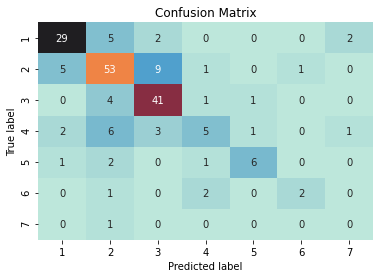

In [30]:
cm = confusion_matrix(annots_prot, prot_preds)
plot = sns.heatmap(cm, annot=True, center=30.0, cbar=False)
plot.set_xticklabels([1,2,3,4,5,6,7])
plot.set_yticklabels([1,2,3,4,5,6,7])
plot.set_title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")


In [66]:
print(classification_report(annots_prot, prot_preds, digits=4, zero_division=0))

print(f1_score(annots_prot, prot_preds, average='micro'))

print(balanced_accuracy_score(annots_prot, prot_preds))

              precision    recall  f1-score   support

           1     0.7838    0.7632    0.7733        38
           2     0.7361    0.7681    0.7518        69
           3     0.7455    0.8723    0.8039        47
           4     0.5000    0.2778    0.3571        18
           5     0.7500    0.6000    0.6667        10
           6     0.6667    0.4000    0.5000         5
           7     0.0000    0.0000    0.0000         1

    accuracy                         0.7234       188
   macro avg     0.5974    0.5259    0.5504       188
weighted avg     0.7205    0.7234    0.7162       188

0.723404255319149
0.5259131485822172


## Plotting performance for all models

In [6]:
#calculating random basline score from class distribution



rand_acc = []
rand_f1=[]
rand_mcc=[]
for i in range(500):
    random_pred = np.array([])
    length = len(annots_prot)
    for i in range(length):
        random_pred = np.append(random_pred, annots_prot[random.randint(0,length-1)])
    rand_acc.append(accuracy_score(annots_prot, random_pred))
    rand_f1.append(f1_score(annots_prot, random_pred, average='weighted'))
    rand_mcc.append(matthews_corrcoef(annots_prot, random_pred))

print("f1: ", np.mean(rand_f1))
print((np.std(rand_f1) / (math.sqrt(10)))*1.96)

print("accuracy: ", np.mean(rand_acc))
print((np.std(rand_acc) / (math.sqrt(10)))*1.96)

print("mcc: ", np.mean(rand_mcc))
print((np.std(rand_mcc) / (math.sqrt(10)))*1.96)

rand_acc = np.asarray(rand_acc)
rand_f1 = np.asarray(rand_f1)
rand_mcc = np.asarray(rand_mcc)


f1:  0.25118182712095116
0.018410052416325966
accuracy:  0.2525425531914894
0.018984065167057588
mcc:  0.0015780240257522457
0.024467060642052247


In [56]:
f = h5py.File("data/bootstrapping_scores_final500.hdf5", "r")
tpred_acc = np.array(f['accuracy'])
tpred_f1 = np.array(f['f1'])
tpred_mcc = np.array(f['mcc'])

model1 = np.full((len(rand_acc)), 'Random')
model2 = np.full((len(pred_acc)), 'PR: Validation Set')
model3 = np.full((len(tpred_acc)), 'PR: Test Set')
#model: array with Model labels: Random, Val, Test, Random, Val, Test, Random, Val, Test
model = np.concatenate((model1, model2, model3, model1, model2, model3, model1, model2, model3))

#Bootstrapped values for each model: random accuracies, val. accur, test accur, rand f1, val f1, test f1, rand mcc, val mcc, test mcc
value = np.concatenate((rand_acc, pred_acc, tpred_acc, rand_f1, pred_f1, tpred_f1, rand_mcc, pred_mcc, tpred_mcc))

measure1 = np.full((len(rand_acc)+len(pred_acc)+len(tpred_acc)), 'Accuracy')
measure2 = np.full((len(rand_acc)+len(pred_acc)+len(tpred_acc)), 'F1 Score')
measure3 = np.full((len(rand_acc)+len(pred_acc)+len(tpred_acc)), 'MCC')
#Label of the metric used: Accuracy, F1, MCC
measure = np.concatenate((measure1, measure2, measure3))

dataset = {'Measure': measure, 'Value': value, 'Model': model}
perf_comp_pr = pd.DataFrame(data=dataset)
perf_comp_pr

,Measure,Value,Model
0,Accuracy,0.260638,Random
1,Accuracy,0.250000,Random
2,Accuracy,0.276596,Random
3,Accuracy,0.255319,Random
4,Accuracy,0.292553,Random
...,...,...,...
4495,MCC,0.657816,PR: Test Set
4496,MCC,0.617143,PR: Test Set
4497,MCC,0.677308,PR: Test Set
4498,MCC,0.668179,PR: Test Set


## Here is the graph for performance assesment 
### hue = what you're comparing (can make it validation vs test, per-residue vs per-protein, etc.)

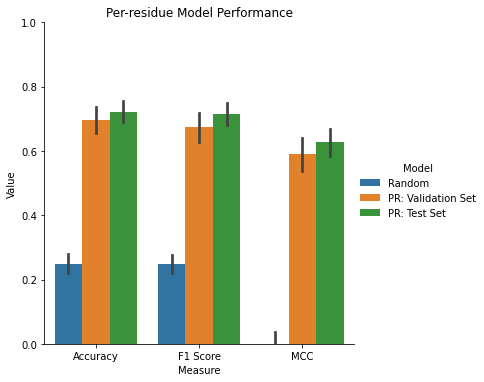

In [61]:
#PER RESIDUE PLOT
residue_plot = sns.catplot(data=perf_comp_pr, x='Measure', y='Value', hue='Model', kind='bar', ci='sd')
residue_plot.set(ylim=(0,1), title="Per-residue Model Performance")
residue_plot.savefig('output/PR_perf_chart.eps', format='eps')

In [3]:
#per residue test data
f = h5py.File("data/bootstrapping_scores_final500.hdf5", "r")
tpred_acc = np.array(f['accuracy'])
tpred_f1 = np.array(f['f1'])
tpred_mcc = np.array(f['mcc'])

#PER PROTEIN BOOTSTRAPPED ARRAYS
file_acc = pd.read_csv('data/per_protein/bootstrapping_test_acc_pp.txt')
file_f1 = pd.read_csv('data/per_protein/bootstrapping_test_f1_pp.txt')
file_mcc = pd.read_csv('data/per_protein/bootstrapping_test_mcc_pp.txt')

file_acc2 = pd.read_csv('data/per_protein/bootstrapping_val_acc_pp.txt')
file_f12 = pd.read_csv('data/per_protein/bootstrapping_val_f1_pp.txt')
file_mcc2 = pd.read_csv('data/per_protein/bootstrapping_val_mcc_pp.txt')

test_acc_pp = np.array(file_acc['0'])
test_f1_pp = np.array(file_f1['0'])
test_mcc_pp = np.array(file_mcc['0'])

val_acc_pp = np.array(file_acc2['0'])
val_f1_pp = np.array(file_f12['0'])
val_mcc_pp = np.array(file_mcc2['0'])

In [13]:
#COMPARISON RESIDUE VS PROTEIN

model1 = np.full((len(rand_acc)), 'Random')
model2 = np.full((len(tpred_acc)), 'PR: Test Set')
model3 = np.full((len(test_acc_pp)), 'PP: Test Set')
#model: array with Model labels: Random, Val, Test, Random, Val, Test, Random, Val, Test
model = np.concatenate((model1, model2, model3, model1, model2, model3, model1, model2, model3))

#Bootstrapped values for each model: random accuracies, val. accur, test accur, rand f1, val f1, test f1, rand mcc, val mcc, test mcc
value = np.concatenate((rand_acc, tpred_acc, test_acc_pp, rand_f1, tpred_f1,test_f1_pp, rand_mcc, tpred_mcc, test_mcc_pp))

measure1 = np.full((len(rand_acc)+len(tpred_acc)+len(test_acc_pp)), 'Accuracy')
measure2 = np.full((len(rand_acc)+len(tpred_acc)+len(test_acc_pp)), 'F1 Score')
measure3 = np.full((len(rand_acc)+len(tpred_acc)+len(test_acc_pp)), 'MCC')
#Label of the metric used: Accuracy, F1, MCC
measure = np.concatenate((measure1, measure2, measure3))

dataset = {'Measure': measure, 'Value': value, 'Model': model}
perf_comp_pr_pp = pd.DataFrame(data=dataset)
perf_comp_pr_pp

,Measure,Value,Model
0,Accuracy,0.292553,Random
1,Accuracy,0.239362,Random
2,Accuracy,0.297872,Random
3,Accuracy,0.228723,Random
4,Accuracy,0.308511,Random
...,...,...,...
4495,MCC,0.666442,PP: Test Set
4496,MCC,0.693810,PP: Test Set
4497,MCC,0.669391,PP: Test Set
4498,MCC,0.577035,PP: Test Set


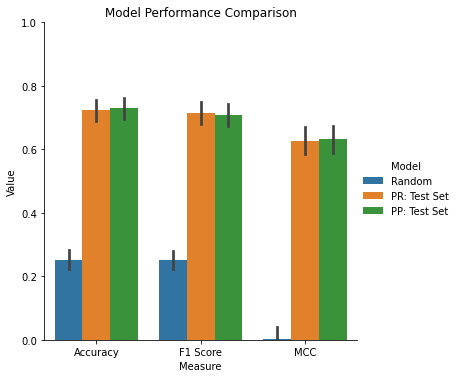

In [15]:
#comparison plot
compare = sns.catplot(data=perf_comp_pr_pp, x='Measure', y='Value', hue='Model', kind='bar', ci='sd')
compare.set(ylim=(0,1), title="Model Performance Comparison")
compare.savefig('output/model_comparision_graph.eps', format='eps')

In [26]:
#COMPARISON VALIDATION SET

#COMPARISON RESIDUE VS PROTEIN

model1 = np.full((len(rand_acc)), 'Random')
model2 = np.full((len(vpred_acc)), 'PR: Validation Set')
model3 = np.full((len(val_acc_pp)), 'PP: Validation Set')
#model: array with Model labels: Random, Val, Test, Random, Val, Test, Random, Val, Test
model = np.concatenate((model1, model2, model3, model1, model2, model3, model1, model2, model3))

#Bootstrapped values for each model: random accuracies, val. accur, test accur, rand f1, val f1, test f1, rand mcc, val mcc, test mcc
value = np.concatenate((rand_acc, vpred_acc, val_acc_pp, rand_f1, vpred_f1, val_f1_pp, rand_mcc, vpred_mcc, val_mcc_pp))

measure1 = np.full((len(rand_acc)+len(vpred_acc)+len(val_acc_pp)), 'Accuracy')
measure2 = np.full((len(rand_acc)+len(vpred_acc)+len(val_acc_pp)), 'F1 Score')
measure3 = np.full((len(rand_acc)+len(vpred_acc)+len(val_acc_pp)), 'MCC')
#Label of the metric used: Accuracy, F1, MCC
measure = np.concatenate((measure1, measure2, measure3))

dataset = {'Measure': measure, 'Value': value, 'Model': model}
perf_comp_val = pd.DataFrame(data=dataset)
perf_comp_val

,Measure,Value,Model
0,Accuracy,0.292553,Random
1,Accuracy,0.239362,Random
2,Accuracy,0.297872,Random
3,Accuracy,0.228723,Random
4,Accuracy,0.308511,Random
...,...,...,...
4495,MCC,0.604365,PP: Validation Set
4496,MCC,0.658969,PP: Validation Set
4497,MCC,0.716332,PP: Validation Set
4498,MCC,0.574299,PP: Validation Set


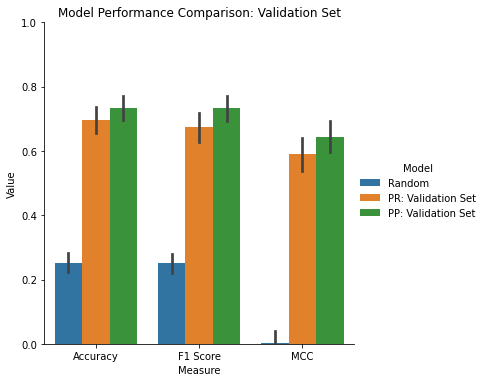

In [30]:
#comparison plot validation
vcompare = sns.catplot(data=perf_comp_val, x='Measure', y='Value', hue='Model', kind='bar', ci='sd')
vcompare.set(ylim=(0,1), title="Model Performance Comparison: Validation Set")
vcompare.savefig('output/model_comparision_graph_validation.eps', format='eps')

In [16]:
#PER PROTEIN PLOT
model1 = np.full((len(rand_acc)), 'Random')
model2 = np.full((len(val_acc_pp)), 'PP: Validation Set')
model3 = np.full((len(test_acc_pp)), 'PP: Test Set')
#model: array with Model labels: Random, Val, Test, Random, Val, Test, Random, Val, Test
model = np.concatenate((model1, model2, model3, model1, model2, model3, model1, model2, model3))

#Bootstrapped values for each model: random accuracies, val. accur, test accur, rand f1, val f1, test f1, rand mcc, val mcc, test mcc
value = np.concatenate((rand_acc, val_acc_pp, test_acc_pp, rand_f1, val_f1_pp, test_f1_pp, rand_mcc, val_mcc_pp, test_mcc_pp))

measure1 = np.full((len(rand_acc)+len(val_acc_pp)+len(test_acc_pp)), 'Accuracy')
measure2 = np.full((len(rand_acc)+len(val_acc_pp)+len(test_acc_pp)), 'F1 Score')
measure3 = np.full((len(rand_acc)+len(val_acc_pp)+len(test_acc_pp)), 'MCC')
#Label of the metric used: Accuracy, F1, MCC
measure = np.concatenate((measure1, measure2, measure3))

dataset = {'Measure': measure, 'Value': value, 'Model': model}
perf_comp_pp = pd.DataFrame(data=dataset)
perf_comp_pp


,Measure,Value,Model
0,Accuracy,0.292553,Random
1,Accuracy,0.239362,Random
2,Accuracy,0.297872,Random
3,Accuracy,0.228723,Random
4,Accuracy,0.308511,Random
...,...,...,...
4495,MCC,0.666442,PP: Test Set
4496,MCC,0.693810,PP: Test Set
4497,MCC,0.669391,PP: Test Set
4498,MCC,0.577035,PP: Test Set


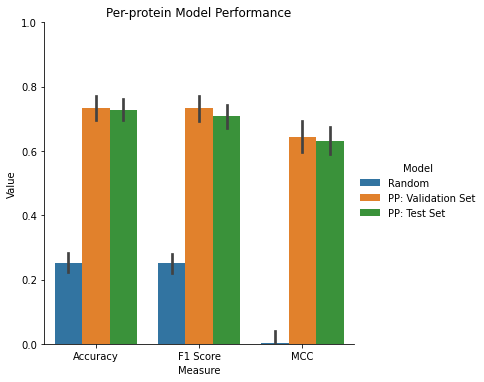

In [19]:
#per protein plot
protein_plot = sns.catplot(data=perf_comp_pp, x='Measure', y='Value', hue='Model', kind='bar', ci='sd')
protein_plot.set(ylim=(0,1), title="Per-protein Model Performance")
protein_plot.savefig('output/PP_perf_chart.eps', format='eps')

In [5]:
#actual values and CIs

def mean_confidence_interval(data, confidence=0.95):
    se = np.std(data)
    n = len(data)
    m = np.mean(data)
    ci = se * st.t.ppf((1+0.95)/2, n)
    return m, se, ci

def ci(data, confidence=0.95):
    se = np.std(data)
    n = len(data)
    m = np.mean(data)
    ci = se * st.t.ppf((1+0.95)/2, n)
    return ci


In [16]:
#PREDICTOR PR TEST SET
pr_acc, acc_se, acc_ci = mean_confidence_interval(pred_acc)
print('Accuracy: ', round(pr_acc, 3), "+/-", round(acc_ci, 3))
print(acc_se)

pr_f1, f1_se, f1_ci = mean_confidence_interval(pred_f1)
print('F1 Score: ', round(pr_f1, 3), "+/-", round(f1_ci, 3))
print(f1_se)

pr_mcc, mcc_se, mcc_ci = mean_confidence_interval(pred_mcc)
print('MCC: ', round(pr_mcc, 3), "+/-", round(mcc_ci, 3))
print(mcc_se)

Accuracy:  0.723 +/- 0.063
0.03229402466358731
F1 Score:  0.714 +/- 0.067
0.033938296476843904
MCC:  0.627 +/- 0.083
0.04249656428955435


In [22]:
#PREDICTOR PR VAL SET
vpr_acc, vacc_se, vacc_ci = mean_confidence_interval(pred_acc)
print('Accuracy: ', round(vpr_acc, 3), "+/-", round(vacc_ci, 3))
print(vacc_se)

vpr_f1, vf1_se, vf1_ci = mean_confidence_interval(pred_f1)
print('F1 Score: ', round(vpr_f1, 3), "+/-", round(vf1_ci, 3))
print(vf1_se)

vpr_mcc, vmcc_se, vmcc_ci = mean_confidence_interval(pred_mcc)
print('MCC: ', round(vpr_mcc, 3), "+/-", round(vmcc_ci, 3))
print(vmcc_se)

Accuracy:  0.697 +/- 0.079
0.040112863897803414
F1 Score:  0.673 +/- 0.087
0.04412609746602267
MCC:  0.589 +/- 0.103
0.052480724197099024


In [6]:
#PREDICTOR PP TEST SET
pp_acc, pp_acc_se, pp_acc_ci = mean_confidence_interval(test_acc_pp)
print('Accuracy: ', round(pp_acc, 3), "+/-", round(pp_acc_ci, 3))
print(pp_acc_se)

pp_f1, ppf1_se, ppf1_ci = mean_confidence_interval(test_f1_pp)
print('F1 Score: ', round(pp_f1, 3), "+/-", round(ppf1_ci, 3))
print(ppf1_se)

pp_mcc, ppmcc_se, ppmcc_ci = mean_confidence_interval(test_mcc_pp)
print('MCC: ', round(pp_mcc, 3), "+/-", round(ppmcc_ci, 3))
print(ppmcc_se)

Accuracy:  0.728 +/- 0.063
0.032201022340082486
F1 Score:  0.708 +/- 0.07
0.0354347230602361
MCC:  0.632 +/- 0.083
0.04236973628826865


In [108]:
#RANDOM 
rd_acc, racc_ci = mean_confidence_interval(rand_acc)
print('Accuracy: ', round(rd_acc, 3), "+/-", round(racc_ci, 3))

rd_f1, rf1_ci = mean_confidence_interval(rand_f1)
print('F1 Score: ', round(rd_f1, 3), "+/-", round(rf1_ci, 3))

rd_mcc, rmcc_ci = mean_confidence_interval(rand_mcc)
print('MCC: ', round(rd_mcc, 3), "+/-", round(rmcc_ci, 3))

Accuracy:  0.25 +/- 0.003
F1 Score:  0.249 +/- 0.003
MCC:  -0.001 +/- 0.004


## T test comparison of PR vs PP

In [49]:
print(tpred_acc)
print(test_acc_pp)

[0.72340426 0.77659574 0.68085106 0.65425532 0.70744681 0.77659574
 0.75       0.76595745 0.73404255 0.7712766  0.72340426 0.68617021
 0.7287234  0.71808511 0.7287234  0.69148936 0.76595745 0.7712766
 0.75531915 0.75531915 0.71276596 0.68617021 0.69148936 0.72340426
 0.70744681 0.72340426 0.74468085 0.73404255 0.70212766 0.7287234
 0.7393617  0.66489362 0.70744681 0.69148936 0.71808511 0.75531915
 0.67021277 0.72340426 0.72340426 0.73404255 0.75531915 0.71808511
 0.76595745 0.76595745 0.78191489 0.7393617  0.75531915 0.75531915
 0.78191489 0.75       0.71808511 0.69680851 0.75       0.7712766
 0.70212766 0.70212766 0.69148936 0.67553191 0.71808511 0.7287234
 0.72340426 0.74468085 0.69148936 0.74468085 0.71276596 0.76595745
 0.70744681 0.7606383  0.65957447 0.69148936 0.71808511 0.70212766
 0.74468085 0.75       0.7712766  0.75       0.75531915 0.7287234
 0.7287234  0.74468085 0.75531915 0.7287234  0.72340426 0.7287234
 0.7287234  0.71276596 0.71808511 0.72340426 0.7287234  0.71808511
 

In [20]:
#t-test per prot vs per res TWO SIDED

ttest_acc = st.ttest_rel(tpred_acc, test_acc_pp)
ttest_f1 = st.ttest_rel(tpred_f1, test_f1_pp)
ttest_mcc = st.ttest_rel(tpred_mcc, test_mcc_pp)

print(ttest_acc)
print(ttest_f1)
print(ttest_mcc)


Ttest_relResult(statistic=-2.924908618385744, pvalue=0.0036023886932048275)
Ttest_relResult(statistic=3.033194172457207, pvalue=0.0025458242744623434)
Ttest_relResult(statistic=-1.7093164389140625, pvalue=0.08801408605267863)


In [34]:
#ONE SIDED
# H0 = pp < pr
# Ha = pp > pr

tt_acc = st.ttest_rel(tpred_acc, test_acc_pp, alternative='less')
tt_f1 = st.ttest_rel(tpred_f1, test_f1_pp, alternative='greater')
tt_mcc = st.ttest_rel(tpred_mcc, test_mcc_pp, alternative='less')

print(tt_acc)
print(tt_f1)
print(tt_mcc)

Ttest_relResult(statistic=-2.924908618385744, pvalue=0.0018011943466024138)
Ttest_relResult(statistic=3.033194172457207, pvalue=0.0012729121372311717)
Ttest_relResult(statistic=-1.7093164389140625, pvalue=0.044007043026339315)


In [31]:
#VALIDATION SET

vttest_acc = st.ttest_rel(vpred_acc, val_acc_pp, alternative='less')
vttest_f1 = st.ttest_rel(vpred_f1, val_f1_pp, alternative='less')
vttest_mcc = st.ttest_rel(vpred_mcc, val_mcc_pp, alternative='less')

print(vttest_acc)
print(vttest_f1)
print(vttest_mcc)

Ttest_relResult(statistic=-15.041754975122952, pvalue=9.69252410872093e-43)
Ttest_relResult(statistic=-22.86592697994456, pvalue=5.373418644592855e-80)
Ttest_relResult(statistic=-17.5378285390053, pvalue=2.677658848374452e-54)


In [32]:
print("{:.7f}". format(vttest_acc.pvalue))
print("{:.10f}". format(vttest_f1.pvalue))
print("{:.7f}". format(vttest_mcc.pvalue))

0.0000000
0.0000000000
0.0000000
